In [1]:
import music21 as m2
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import collections  as mc
import glob
from collections import Counter

from scipy.stats import zscore
from scipy.signal import savgol_filter

In [2]:
def get_drumbeat_ticks_for_midi(midi_path):
    mf = m2.midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    ev = mf.tracks[0].events
    df = pd.DataFrame(data=[e.__dict__ for e in ev])
    df.insert(2,'type_str',df.type.map(lambda t: str(t).split('.')[-1]))
    df.insert(4,'time_abs',df.time.cumsum())
    #print(mf.ticksPerQuarterNote)
    all_events = {}
    open_events = {}
    for row in df[df.type_str.isin(['NOTE_ON','NOTE_OFF'])].itertuples():
        if row.type_str=='NOTE_ON':
            open_events[row.parameter1]=row.time_abs
        else:
            all_events[row.parameter1]=all_events.get(row.parameter1,[])+[(open_events[row.parameter1], row.time_abs)]


    return all_events

In [5]:
midi_files = glob.glob('../../../data/MIDI-Freestyle/Freestyle_*.mid')
group_number = lambda fname: int(fname.split('_')[1][:4])
file_list = sorted([file for file in midi_files if group_number(file) <= 1013 or group_number(file) >=1042])
file_list

['../../../data/MIDI-Freestyle/Freestyle_1001.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1002.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1003.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1004.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1005.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1006.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1007.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1008.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1009.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1010.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1011.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1012.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1013.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1042.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1043.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1044.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1045.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1046.mid',
 '../../../data/MIDI-Freestyle/Freestyle_1047.mid',
 '../../../d

In [6]:

all_events = { group_number(file): get_drumbeat_ticks_for_midi(file) for file in file_list}

event_counts = {g: {k: len(v) for k, v in lst.items()} for g,lst in all_events.items()}
    

In [7]:
event_duration = {g: 
    {k: Counter([a[1]-a[0] for a in v]).most_common(7) 
         for k, v in lst.items()
    } for g, lst in all_events.items()}

event_duration

{1001: {43: [(13, 425), (12, 149), (14, 82), (7, 13), (6, 10), (4, 6), (5, 6)],
  45: [(13, 434), (12, 153), (14, 81), (6, 52), (5, 42), (7, 32), (4, 32)],
  48: [(13, 458), (12, 135), (14, 83), (9, 8), (7, 8), (8, 5), (6, 4)]},
 1002: {48: [(13, 354), (12, 134), (14, 72), (1, 6), (5, 5), (4, 4), (7, 3)],
  43: [(13, 383), (12, 120), (14, 59), (9, 9), (8, 8), (7, 7), (5, 7)],
  45: [(13, 335), (12, 98), (14, 67), (4, 12), (2, 9), (1, 9), (9, 6)]},
 1003: {45: [(13, 215), (12, 66), (14, 39), (2, 4), (8, 3), (7, 2), (1, 2)],
  48: [(13, 254), (12, 78), (14, 39), (2, 3), (1, 1)],
  43: [(13, 231), (12, 68), (14, 38), (9, 1), (6, 1), (7, 1)]},
 1004: {48: [(13, 634), (12, 80), (4, 14), (14, 11), (9, 7), (5, 7), (1, 6)],
  45: [(13, 650), (12, 91), (4, 27), (3, 21), (6, 20), (9, 11), (1, 7)],
  43: [(13, 445), (12, 46), (14, 7)]},
 1005: {45: [(13, 390),
   (12, 156),
   (14, 73),
   (1, 34),
   (2, 31),
   (4, 29),
   (5, 19)],
  48: [(13, 368), (12, 99), (5, 58), (4, 56), (14, 53), (3, 21

In [8]:
event_interval = {g: 
    {k: Counter([(b[1]-a[0])//10 for a,b in zip(v[:-1],v[1:])]).most_common(7) 
         for k, v in lst.items()
    } for g, lst in all_events.items()}

event_interval

{1001: {43: [(3, 214), (7, 71), (5, 67), (6, 58), (4, 56), (9, 46), (8, 40)],
  45: [(1, 163), (4, 155), (3, 132), (5, 110), (2, 83), (6, 69), (7, 45)],
  48: [(3, 139), (4, 122), (5, 96), (6, 95), (7, 56), (2, 43), (8, 33)]},
 1002: {48: [(7, 102), (6, 93), (8, 91), (3, 88), (9, 49), (5, 36), (4, 32)],
  43: [(6, 103), (7, 99), (8, 98), (3, 90), (9, 45), (5, 40), (10, 32)],
  45: [(6, 80), (3, 68), (2, 56), (7, 54), (8, 49), (1, 48), (5, 46)]},
 1003: {45: [(9, 48), (8, 46), (10, 35), (7, 34), (13, 27), (12, 26), (3, 25)],
  48: [(8, 90), (7, 90), (9, 48), (6, 35), (10, 17), (4, 16), (15, 9)],
  43: [(7, 49), (8, 43), (9, 43), (4, 35), (5, 25), (10, 20), (6, 20)]},
 1004: {48: [(3, 181),
   (6, 134),
   (7, 118),
   (4, 111),
   (5, 80),
   (8, 61),
   (1, 34)],
  45: [(6, 183), (3, 182), (5, 122), (4, 98), (1, 76), (7, 76), (8, 46)],
  43: [(6, 80), (7, 79), (5, 60), (3, 55), (4, 53), (10, 38), (8, 37)]},
 1005: {45: [(3, 154), (1, 128), (5, 117), (6, 77), (2, 65), (4, 49), (8, 46)],

In [9]:
events_nonstandard = {g: {k: (sum([a[1] for a in v if a[0] not in {10,11,12,13,14,15}]), event_counts[g][k])
                         for k, v in sorted(lst.items())}
                     for g, lst in event_duration.items()}

events_nonstandard

{1001: {43: (35, 706), 45: (158, 912), 48: (25, 717)},
 1002: {43: (31, 600), 45: (36, 561), 48: (18, 590)},
 1003: {43: (3, 340), 45: (11, 333), 48: (4, 375)},
 1004: {43: (0, 498), 45: (86, 857), 48: (34, 778)},
 1005: {43: (0, 692), 45: (113, 802), 48: (145, 696)},
 1006: {43: (1, 153), 45: (97, 390), 48: (11, 215)},
 1007: {43: (63, 477), 45: (209, 964), 48: (12, 228)},
 1008: {43: (1, 643), 45: (222, 929), 48: (120, 822)},
 1009: {43: (39, 679), 45: (158, 1023), 48: (36, 573)},
 1010: {43: (6, 441), 45: (61, 491), 48: (19, 383)},
 1011: {43: (47, 431), 45: (91, 556), 48: (54, 392)},
 1012: {43: (8, 174), 45: (113, 316), 48: (3, 166)},
 1013: {43: (5, 642), 45: (11, 543), 48: (21, 586)},
 1042: {43: (0, 471), 45: (23, 702), 48: (0, 516)},
 1043: {43: (13, 473), 45: (12, 662), 48: (90, 638)},
 1044: {43: (1, 695), 45: (66, 713), 48: (122, 808)},
 1045: {43: (17, 665), 45: (0, 664), 48: (2, 643)},
 1046: {43: (25, 732), 45: (20, 493), 48: (8, 782)},
 1047: {43: (88, 597), 45: (35, 62

In [10]:
events_filtered = {gr: {k: [a for a in v if a[1]-a[0]>10] for k, v in lst.items()} for gr, lst in all_events.items() }
events_filtered[1001]

{43: [(2974, 2987),
  (3134, 3147),
  (3314, 3327),
  (3391, 3404),
  (3447, 3461),
  (3484, 3498),
  (3555, 3568),
  (3661, 3674),
  (3782, 3794),
  (3913, 3926),
  (3942, 3955),
  (3993, 4006),
  (4070, 4082),
  (4154, 4166),
  (4291, 4304),
  (4338, 4351),
  (4439, 4452),
  (4482, 4495),
  (4528, 4541),
  (4572, 4584),
  (4633, 4646),
  (4685, 4697),
  (4785, 4798),
  (4834, 4848),
  (4887, 4901),
  (4923, 4935),
  (4961, 4974),
  (4999, 5012),
  (5216, 5229),
  (5280, 5292),
  (5321, 5335),
  (5398, 5411),
  (5440, 5452),
  (5484, 5496),
  (5528, 5541),
  (5611, 5624),
  (5703, 5716),
  (5880, 5893),
  (5980, 5992),
  (6074, 6088),
  (6104, 6116),
  (6146, 6159),
  (6171, 6184),
  (6192, 6205),
  (6214, 6227),
  (6258, 6271),
  (6306, 6318),
  (6355, 6368),
  (6376, 6389),
  (6397, 6410),
  (6462, 6474),
  (6480, 6493),
  (6541, 6554),
  (6599, 6612),
  (6654, 6667),
  (6676, 6688),
  (6719, 6732),
  (6741, 6754),
  (6761, 6774),
  (6783, 6795),
  (6806, 6819),
  (6829, 6842),
  (6

In [11]:
event_interval_filtered = {g: 
    {k: Counter([(b[1]-a[0])//10 for a,b in zip(v[:-1],v[1:])]).most_common(7) 
         for k, v in lst.items()
    } for g, lst in events_filtered.items()}

event_interval[1002], event_interval_filtered[1002]

({48: [(7, 102), (6, 93), (8, 91), (3, 88), (9, 49), (5, 36), (4, 32)],
  43: [(6, 103), (7, 99), (8, 98), (3, 90), (9, 45), (5, 40), (10, 32)],
  45: [(6, 80), (3, 68), (2, 56), (7, 54), (8, 49), (1, 48), (5, 46)]},
 {48: [(7, 107), (6, 93), (8, 91), (3, 89), (9, 50), (5, 31), (4, 29)],
  43: [(6, 106), (7, 101), (8, 98), (3, 92), (9, 45), (10, 34), (5, 33)],
  45: [(6, 81), (3, 77), (7, 58), (8, 50), (5, 40), (2, 36), (9, 27)]})

In [12]:
event_counts

{1001: {43: 706, 45: 912, 48: 717},
 1002: {48: 590, 43: 600, 45: 561},
 1003: {45: 333, 48: 375, 43: 340},
 1004: {48: 778, 45: 857, 43: 498},
 1005: {45: 802, 48: 696, 43: 692},
 1006: {45: 390, 48: 215, 43: 153},
 1007: {48: 228, 45: 964, 43: 477},
 1008: {48: 822, 45: 929, 43: 643},
 1009: {43: 679, 45: 1023, 48: 573},
 1010: {45: 491, 43: 441, 48: 383},
 1011: {45: 556, 48: 392, 43: 431},
 1012: {45: 316, 48: 166, 43: 174},
 1013: {45: 543, 48: 586, 43: 642},
 1042: {45: 702, 48: 516, 43: 471},
 1043: {45: 662, 48: 638, 43: 473},
 1044: {45: 713, 48: 808, 43: 695},
 1045: {48: 643, 43: 665, 45: 664},
 1046: {48: 782, 45: 493, 43: 732},
 1047: {43: 597, 45: 622, 48: 398},
 1048: {45: 668, 43: 737, 48: 657},
 1049: {45: 389, 48: 198, 43: 293},
 1050: {48: 530, 43: 603, 45: 517},
 1051: {45: 676, 43: 705, 48: 598}}

In [14]:
event_counts_sorted = {g: np.array(sorted(lst.values())) for g, lst in event_counts.items()}
event_counts_sorted



{1001: array([706, 717, 912]),
 1002: array([561, 590, 600]),
 1003: array([333, 340, 375]),
 1004: array([498, 778, 857]),
 1005: array([692, 696, 802]),
 1006: array([153, 215, 390]),
 1007: array([228, 477, 964]),
 1008: array([643, 822, 929]),
 1009: array([ 573,  679, 1023]),
 1010: array([383, 441, 491]),
 1011: array([392, 431, 556]),
 1012: array([166, 174, 316]),
 1013: array([543, 586, 642]),
 1042: array([471, 516, 702]),
 1043: array([473, 638, 662]),
 1044: array([695, 713, 808]),
 1045: array([643, 664, 665]),
 1046: array([493, 732, 782]),
 1047: array([398, 597, 622]),
 1048: array([657, 668, 737]),
 1049: array([198, 293, 389]),
 1050: array([517, 530, 603]),
 1051: array([598, 676, 705])}

In [15]:
event_counts_diffs = {g : (np.diff(lst).min(), lst[2]-lst[0]) for g, lst in event_counts_sorted.items()}
event_ratios = {g : lst[1]/lst[0] for g, lst in event_counts_diffs.items()}

In [16]:
event_ratios

{1001: 18.727272727272727,
 1002: 3.9,
 1003: 6.0,
 1004: 4.544303797468355,
 1005: 27.5,
 1006: 3.8225806451612905,
 1007: 2.9558232931726907,
 1008: 2.6728971962616823,
 1009: 4.245283018867925,
 1010: 2.16,
 1011: 4.205128205128205,
 1012: 18.75,
 1013: 2.302325581395349,
 1042: 5.133333333333334,
 1043: 7.875,
 1044: 6.277777777777778,
 1045: 22.0,
 1046: 5.78,
 1047: 8.96,
 1048: 7.2727272727272725,
 1049: 2.0105263157894737,
 1050: 6.615384615384615,
 1051: 3.689655172413793}

In [17]:
event_counts_diffs

{1001: (11, 206),
 1002: (10, 39),
 1003: (7, 42),
 1004: (79, 359),
 1005: (4, 110),
 1006: (62, 237),
 1007: (249, 736),
 1008: (107, 286),
 1009: (106, 450),
 1010: (50, 108),
 1011: (39, 164),
 1012: (8, 150),
 1013: (43, 99),
 1042: (45, 231),
 1043: (24, 189),
 1044: (18, 113),
 1045: (1, 22),
 1046: (50, 289),
 1047: (25, 224),
 1048: (11, 80),
 1049: (95, 191),
 1050: (13, 86),
 1051: (29, 107)}

In [18]:
# [1001, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
 # 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051]
sg_rats_interaction = np.array([1.28589801, 1.08080804, 1.30721235, 1.25149081, 1.08867095,
       1.07652876, 1.19221213, 1.21842693, 1.03906657, 1.05316082,
       1.42415502, 1.41584971, 1.0520917 , 1.05667846, 1.09212165,
       1.14198762, 1.23782323, 1.28673302, 1.08631927, 1.1771771 ])

sg_rats_freestyle = np.array([ 1.458, -1.107, -0.064,  0.058, -1.006,  0.403,  2.329, -0.968, -0.233,  0.287,
  -1.683,  0.764, -0.558, -0.357, -1.035,  0.573, -0.99,   1.163, -0.194,  1.159])

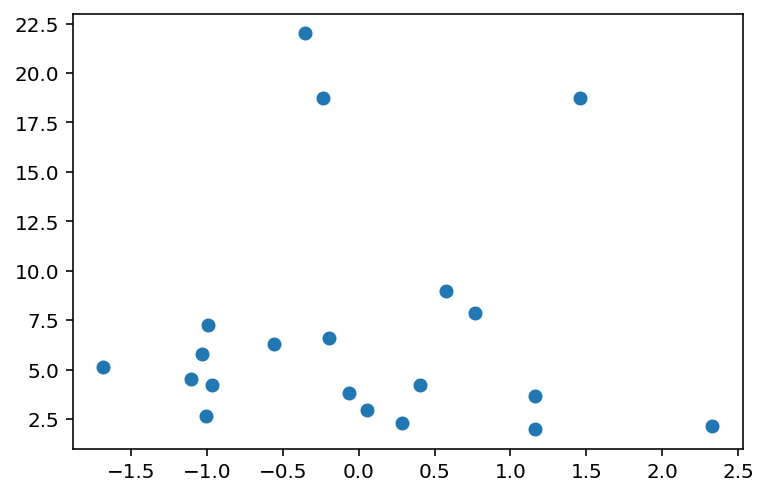

In [19]:
plt.scatter(sg_rats_freestyle,
            [
                event_ratios[k] 
                for k in  [1001, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
                      1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051]
            ]
           )

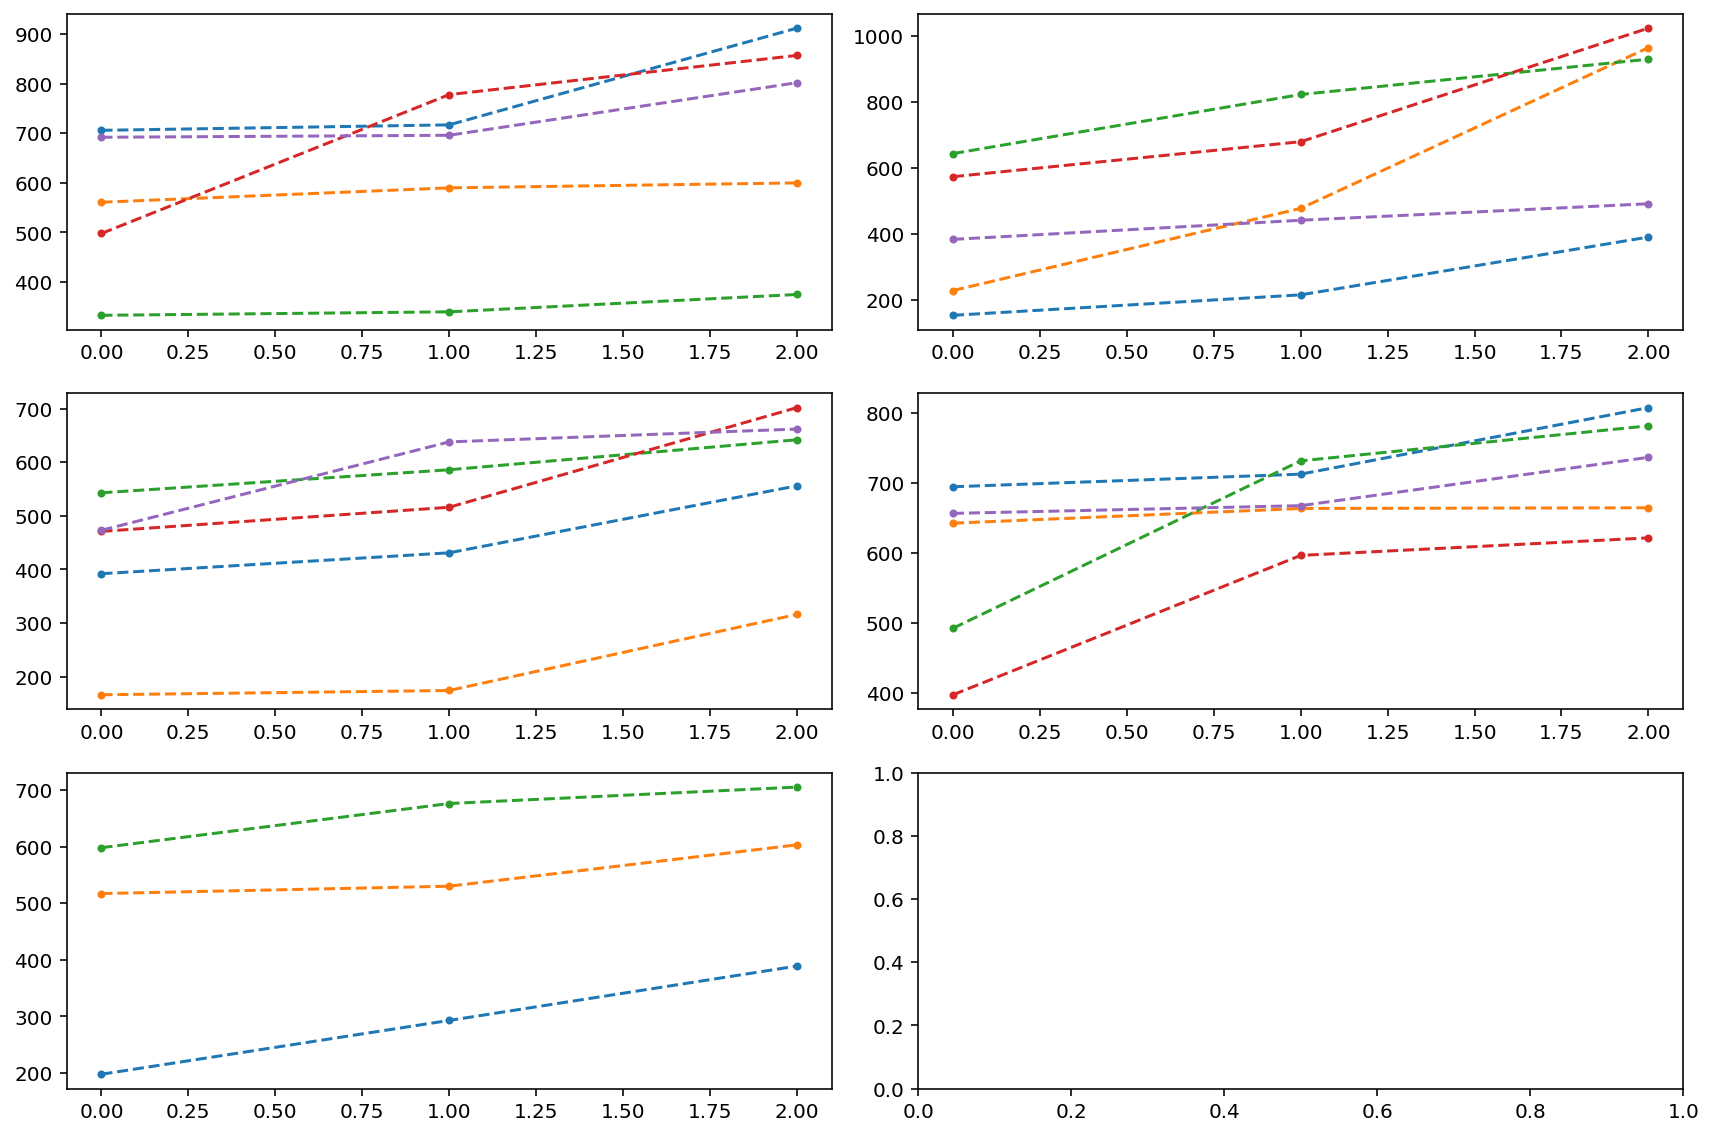

In [21]:
_, axs=plt.subplots(3,2,figsize=(12,8))
for i,v in enumerate(event_counts_sorted.values()):
    #plt.subplot(3,2,i//5+1)
    axs[i//10,(i//5)%2].plot(np.arange(3),v,'.--')
    
plt.tight_layout()
    

In [22]:
event_counts_arr = np.vstack(event_counts_sorted.values())
event_counts_arr

/home/siegman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([[ 706,  717,  912],
       [ 561,  590,  600],
       [ 333,  340,  375],
       [ 498,  778,  857],
       [ 692,  696,  802],
       [ 153,  215,  390],
       [ 228,  477,  964],
       [ 643,  822,  929],
       [ 573,  679, 1023],
       [ 383,  441,  491],
       [ 392,  431,  556],
       [ 166,  174,  316],
       [ 543,  586,  642],
       [ 471,  516,  702],
       [ 473,  638,  662],
       [ 695,  713,  808],
       [ 643,  664,  665],
       [ 493,  732,  782],
       [ 398,  597,  622],
       [ 657,  668,  737],
       [ 198,  293,  389],
       [ 517,  530,  603],
       [ 598,  676,  705]])

In [23]:
from scipy.stats import spearmanr

In [24]:
spearmanr(event_counts_arr)[1]

array([[7.46938006e-166, 2.82269487e-006, 8.50031969e-004],
       [2.82269487e-006, 0.00000000e+000, 2.15767121e-006],
       [8.50031969e-004, 2.15767121e-006, 0.00000000e+000]])

In [25]:
event_diff_arr = np.vstack([v for k, v in event_counts_diffs.items() if k != 1007])
event_diff_arr

array([[ 11, 206],
       [ 10,  39],
       [  7,  42],
       [ 79, 359],
       [  4, 110],
       [ 62, 237],
       [107, 286],
       [106, 450],
       [ 50, 108],
       [ 39, 164],
       [  8, 150],
       [ 43,  99],
       [ 45, 231],
       [ 24, 189],
       [ 18, 113],
       [  1,  22],
       [ 50, 289],
       [ 25, 224],
       [ 11,  80],
       [ 95, 191],
       [ 13,  86],
       [ 29, 107]])

In [26]:
spearmanr(event_counts_arr)

SpearmanrResult(correlation=array([[1.        , 0.80998273, 0.64689896],
       [0.80998273, 1.        , 0.81521739],
       [0.64689896, 0.81521739, 1.        ]]), pvalue=array([[7.46938006e-166, 2.82269487e-006, 8.50031969e-004],
       [2.82269487e-006, 0.00000000e+000, 2.15767121e-006],
       [8.50031969e-004, 2.15767121e-006, 0.00000000e+000]]))

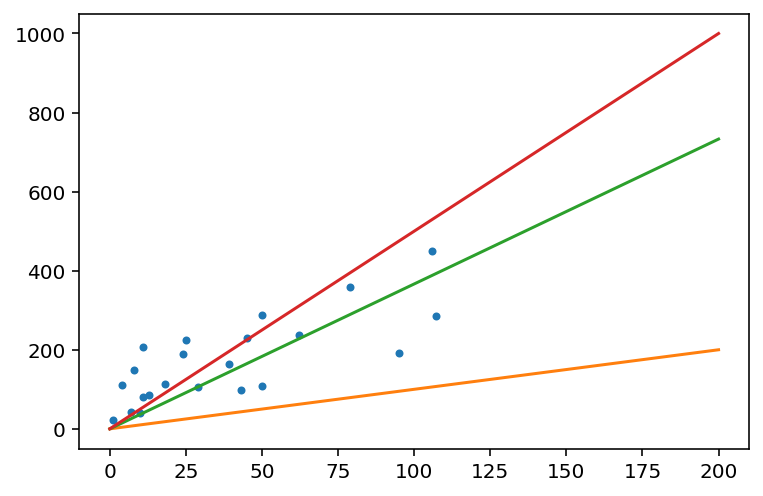

In [27]:
plt.plot(event_diff_arr[:,0],event_diff_arr[:,1],'.')
plt.plot([0,200],[0,200])
plt.plot([0,200],[0,200*3.6647])
plt.plot([0,200],[0,1000])

In [28]:

from sklearn.linear_model import LinearRegression

In [29]:
lr = LinearRegression(fit_intercept=False)
lr.fit(event_diff_arr[:,:1],event_diff_arr[:,1:])

LinearRegression(fit_intercept=False)

In [30]:
lr.coef_, lr.intercept_

(array([[3.66474627]]), 0.0)

In [31]:
event_ratios_arr = np.hstack([event_counts_arr[:,1:2]/ event_counts_arr[:,0:1],
                               event_counts_arr[:,2:3]/ event_counts_arr[:,1:2]])
event_ratios_arr

array([[1.01558074, 1.27196653],
       [1.0516934 , 1.01694915],
       [1.02102102, 1.10294118],
       [1.562249  , 1.10154242],
       [1.00578035, 1.15229885],
       [1.40522876, 1.81395349],
       [2.09210526, 2.02096436],
       [1.27838258, 1.13017032],
       [1.18499127, 1.50662739],
       [1.15143603, 1.11337868],
       [1.0994898 , 1.2900232 ],
       [1.04819277, 1.81609195],
       [1.07918969, 1.09556314],
       [1.0955414 , 1.36046512],
       [1.34883721, 1.03761755],
       [1.02589928, 1.13323983],
       [1.03265941, 1.00150602],
       [1.48478702, 1.06830601],
       [1.5       , 1.04187605],
       [1.01674277, 1.10329341],
       [1.47979798, 1.32764505],
       [1.02514507, 1.13773585],
       [1.13043478, 1.04289941]])

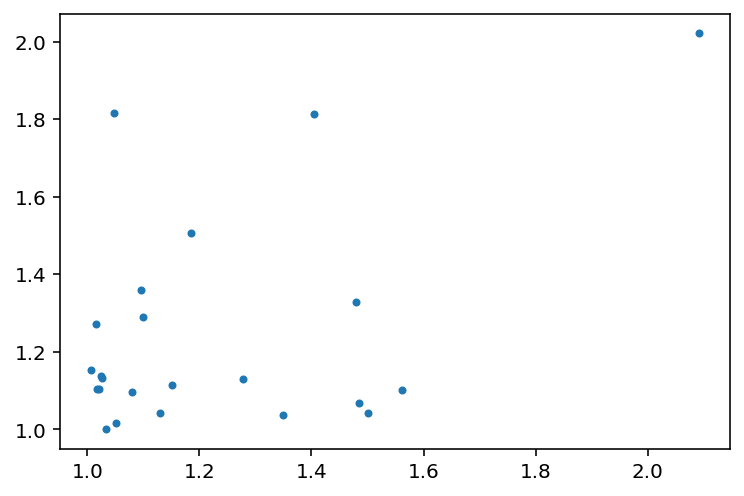

In [32]:
plt.plot(event_ratios_arr[:,0],event_ratios_arr[:,1],'.')

In [33]:
event_counts_arr[:,1:2]

array([[717],
       [590],
       [340],
       [778],
       [696],
       [215],
       [477],
       [822],
       [679],
       [441],
       [431],
       [174],
       [586],
       [516],
       [638],
       [713],
       [664],
       [732],
       [597],
       [668],
       [293],
       [530],
       [676]])

In [34]:
event_counts_arr

array([[ 706,  717,  912],
       [ 561,  590,  600],
       [ 333,  340,  375],
       [ 498,  778,  857],
       [ 692,  696,  802],
       [ 153,  215,  390],
       [ 228,  477,  964],
       [ 643,  822,  929],
       [ 573,  679, 1023],
       [ 383,  441,  491],
       [ 392,  431,  556],
       [ 166,  174,  316],
       [ 543,  586,  642],
       [ 471,  516,  702],
       [ 473,  638,  662],
       [ 695,  713,  808],
       [ 643,  664,  665],
       [ 493,  732,  782],
       [ 398,  597,  622],
       [ 657,  668,  737],
       [ 198,  293,  389],
       [ 517,  530,  603],
       [ 598,  676,  705]])

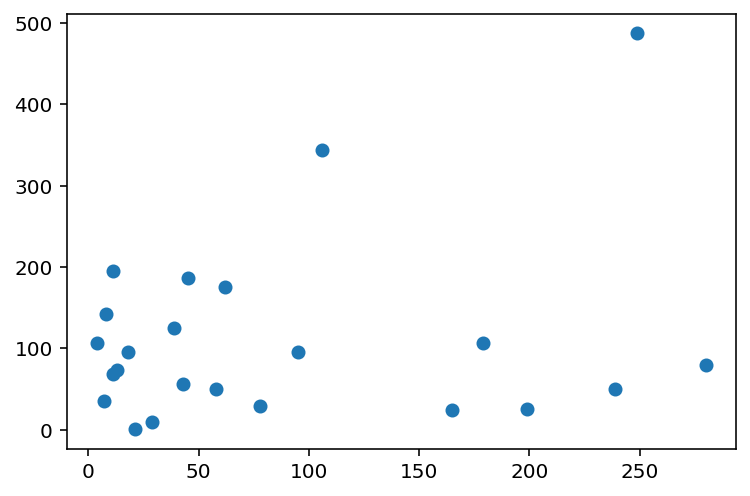

In [35]:
ecs = np.diff(event_counts_arr,axis=1)
plt.scatter(ecs[:,0],ecs[:,1])

## Synchrony dimensions
* does RMS, or a particular synchrony band, predict the outcome better than other types of synchrony?

## Relation between sessions
* what qualities of the groups are preserved between interaction and freestyle
* how does each type of synchrony develop in the four sessions

## synchrony and groups' internal structure
* can groups be divided into: tight group, one tight pair and one farther, loosely coupled? how is each group classified with respect to this internal structure and each synchrony band?

* does this structure predict any feature of the drumming outcome or the psych. outcome better than the average synchrony? 

* is the same structure (i.e. same distant participant) reflected in the responses/drumming synchrony?

## synchrony along time
* can synchrony in time be associated with specific events in the drumming?

## Drumming
* Do the three drummers, as a dynamical system, possess any interesting characteristics?

In [ ]:
all_events[1007]

In [ ]:
[len(v) for v in events_filtered[1001].values()]

In [36]:
def clean_gaps2(group_events, par0,par1, th):
    ev = [[0]+[a[0] for a in group_events[k] ] for k in [par0, par1]]
    l = [len(v)-1 for v in ev]
    cur = [1,1]
    ex = [0,0]
    
    valid = [np.ones(m,dtype=bool) for m in l]

    if ev[0][cur[0]] < ev[1][cur[1]]: 
        i = 0
    else: 
        i = 1
    
    j=0
    k =0
    while k < 2:
       
        while cur[i]+j < l[i] and ev[i][cur[i]+j] <= ev[1-i][cur[1-i]]: j+=1
        if cur[i]+j >= l[i]:
            k+=1

            
        if j >= th:
#             print(
#                 f"filtering {j} beats of {i} between {ev[1-i][cur[1-i]-1]} "+\
#                 f"and {ev[1-i][cur[1-i]]} at index {cur[i]} (index {cur[1-i]})" 
#                 )
            valid[i][(cur[i]-1):(cur[i]+j-1)]=False

        cur[i] +=j
        j=0
        i = 1 - i

    print(f"filtering {np.logical_not(valid[0]).sum()} and {np.logical_not(valid[1]).sum()} strokes")
    return valid

    

In [37]:
def get_relative_phase(group_events, par1,par2, th =0, return_time_diff=False ):
    event_lists = [[a[0] for a in group_events[k] ] for k in [par1, par2]]
    
    if th > 0:
        valid = clean_gaps2(group_events, par1, par2, th)
        event_lists = [[a[0] for a in zip(*lst) if a[1]] for lst in zip(event_lists,valid)] 
    cont_phase = np.interp(event_lists[1], event_lists[0], np.arange(len(event_lists[0])))
    if return_time_diff:
        time_diff = [(np.array(ev)/96,60*96/savgol_filter(ev,13,1,1)) for ev in event_lists]
        return cont_phase, time_diff
    return cont_phase

def hist_relative_phase(cont_phase, m=1, increments=0.05):
    circ_phase = cont_phase % m
    bins, counts = np.unique(
        np.digitize(circ_phase,np.arange(0,m, increments),False)*increments,
        return_counts=True)
    return bins, counts

In [38]:
def analyze_signals(group, par1, par2, base_cycle=1, hist_res=1):
    plt.figure(figsize=(15,6))
    cp, td = get_relative_phase(events_filtered[group],par1,par2,6,True)
    
    plt.subplot(1,3,1)
    plt.plot(cp % base_cycle, '.')
    plt.subplot(1,3,2)
    plt.bar(*hist_relative_phase(cp,base_cycle,0.05 * base_cycle / hist_res),width=base_cycle * 0.02 )
    plt.subplot(1,3,3)
    #plt.plot(np.maximum(0,np.minimum(base_cycle* td/ 5+base_cycle/2, base_cycle)))
    plt.plot(*td[1])
    plt.plot(*td[0])

filtering 0 and 7 strokes


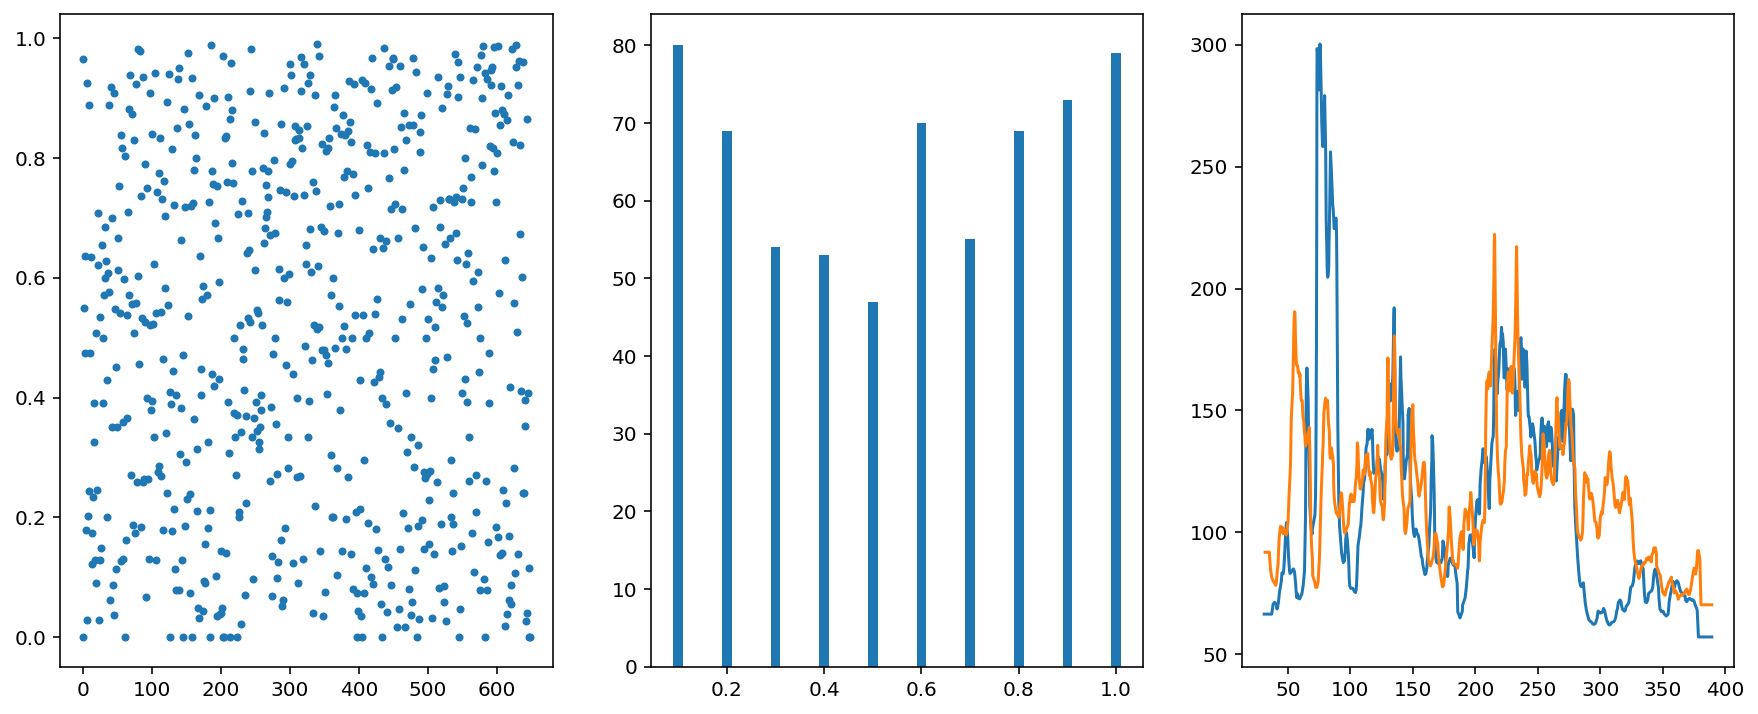

In [39]:
analyze_signals(1001, 45, 43, 1, hist_res=0.5)

filtering 14 and 0 strokes


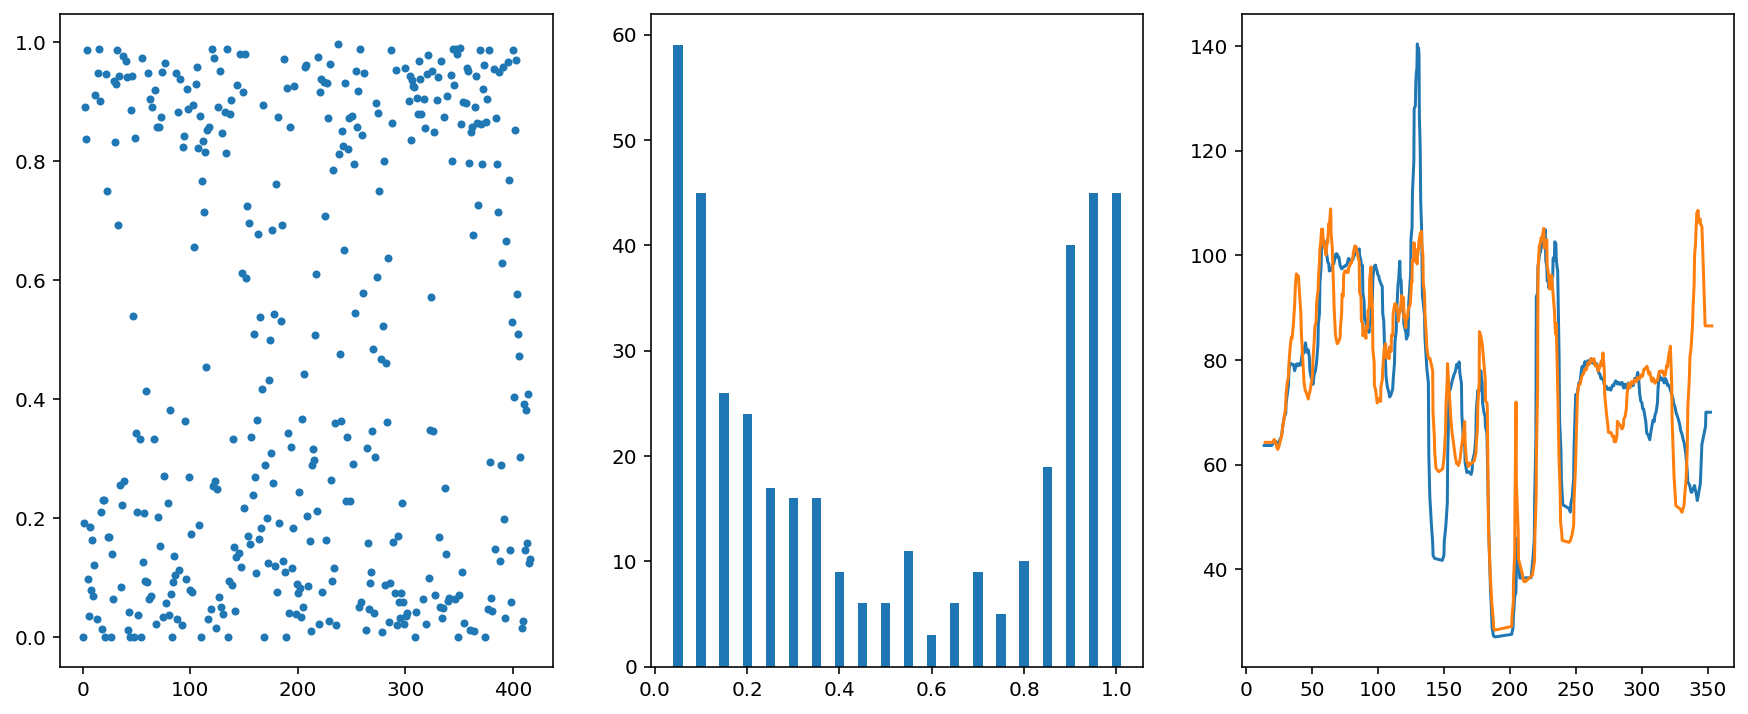

In [529]:
analyze_signals(1010, 43, 45, 1)

filtering 42 and 0 strokes


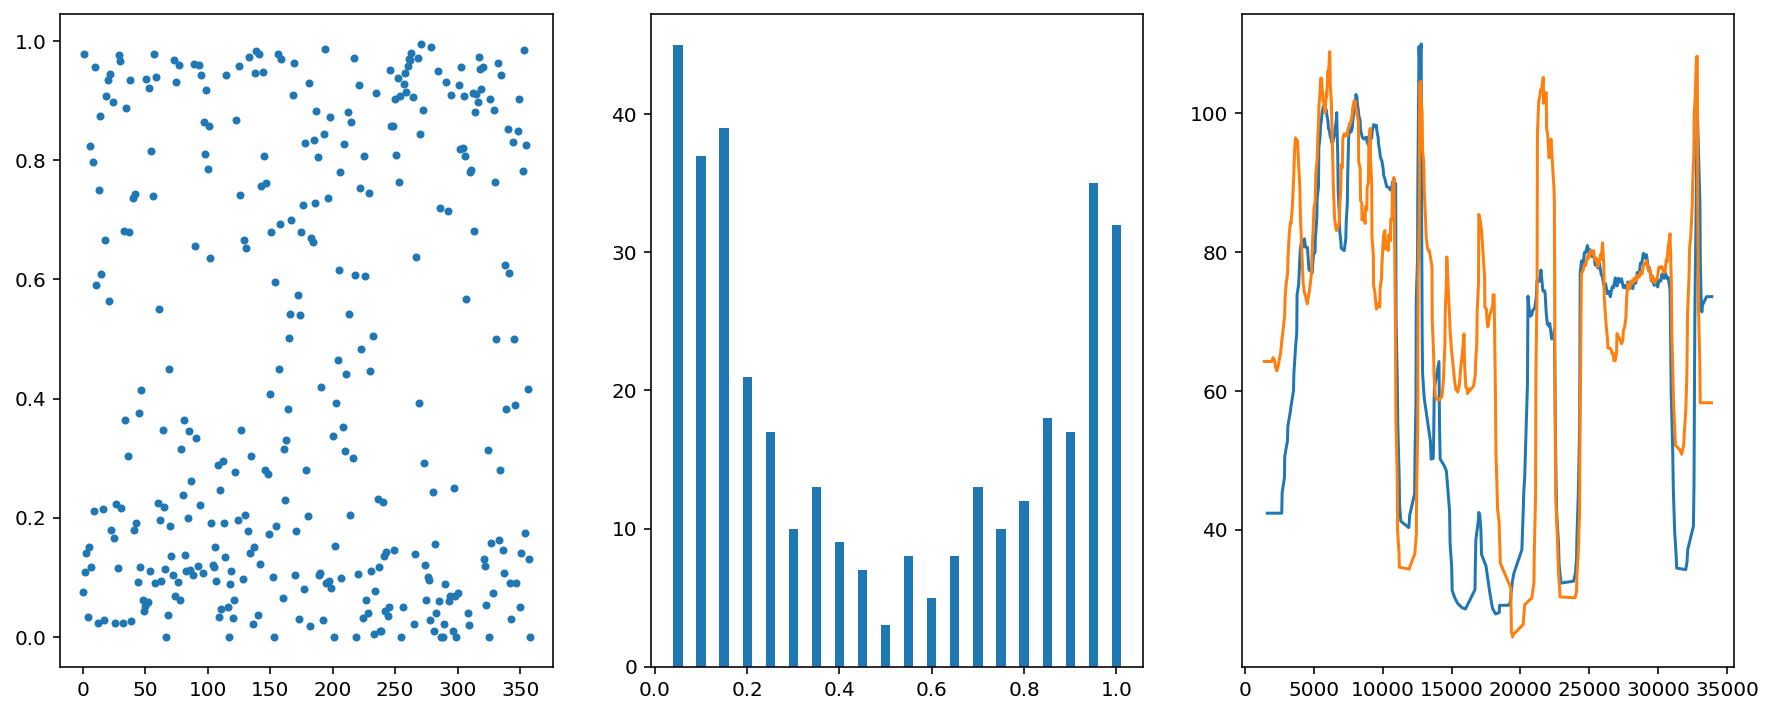

In [516]:
analyze_signals(1010, 43, 48, 1)

filtering 40 and 22 strokes


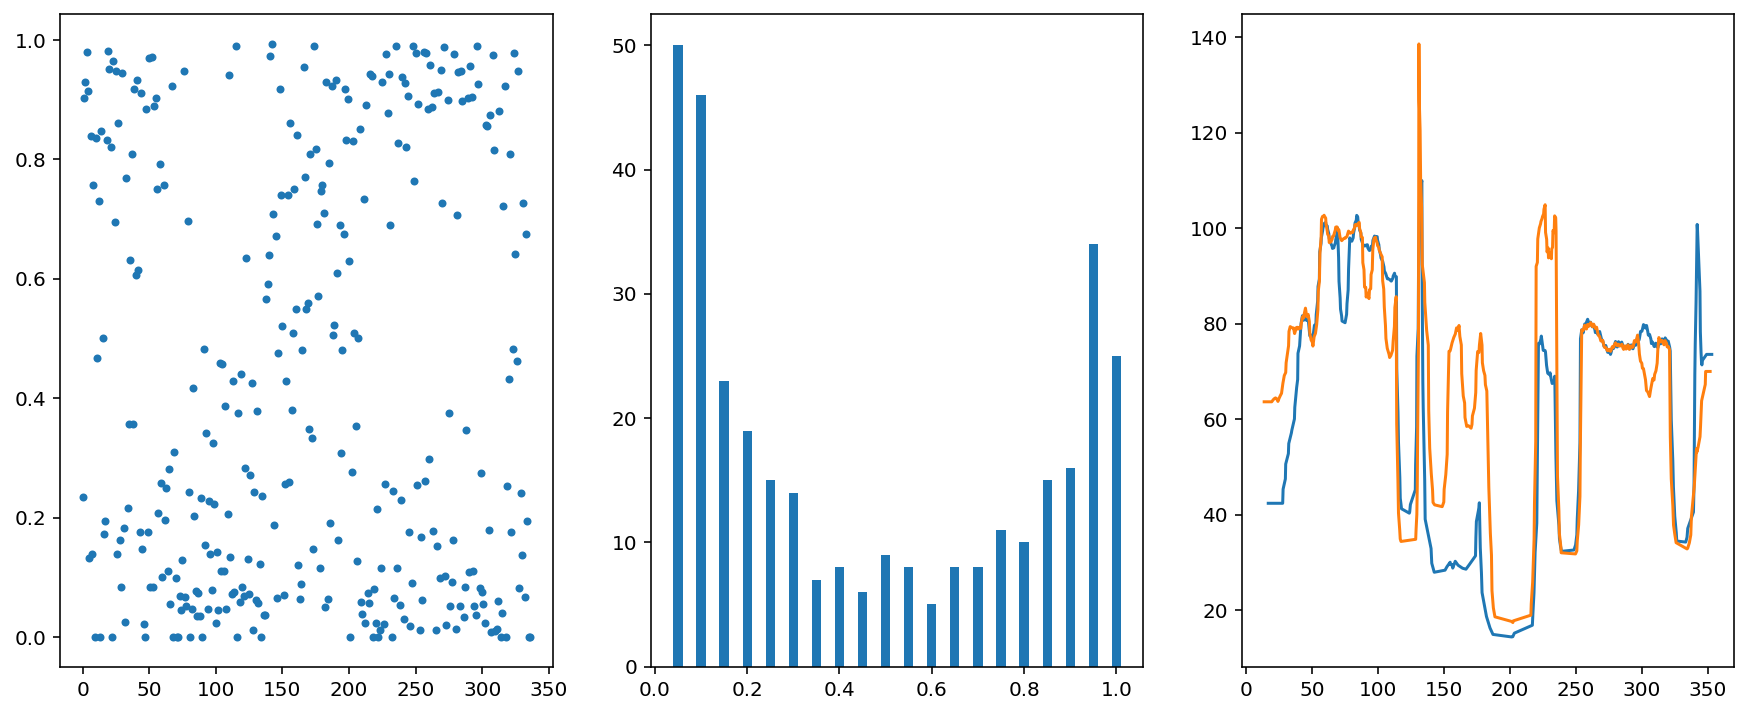

In [40]:
analyze_signals(1010, 45, 48, 1)

filtering 0 and 296 strokes


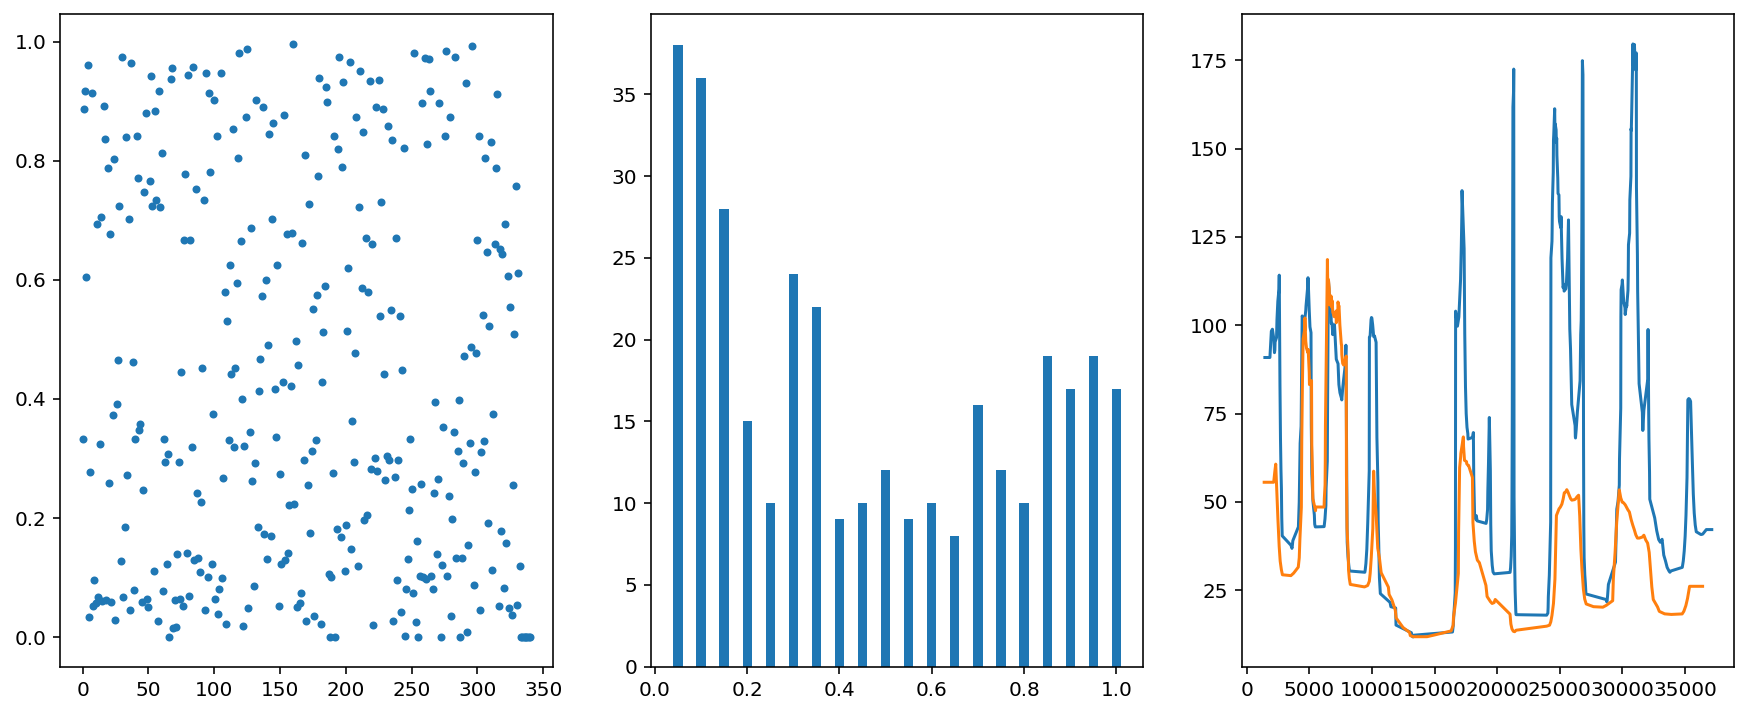

In [522]:
analyze_signals(1007, 48, 45, 1)

filtering 9 and 125 strokes


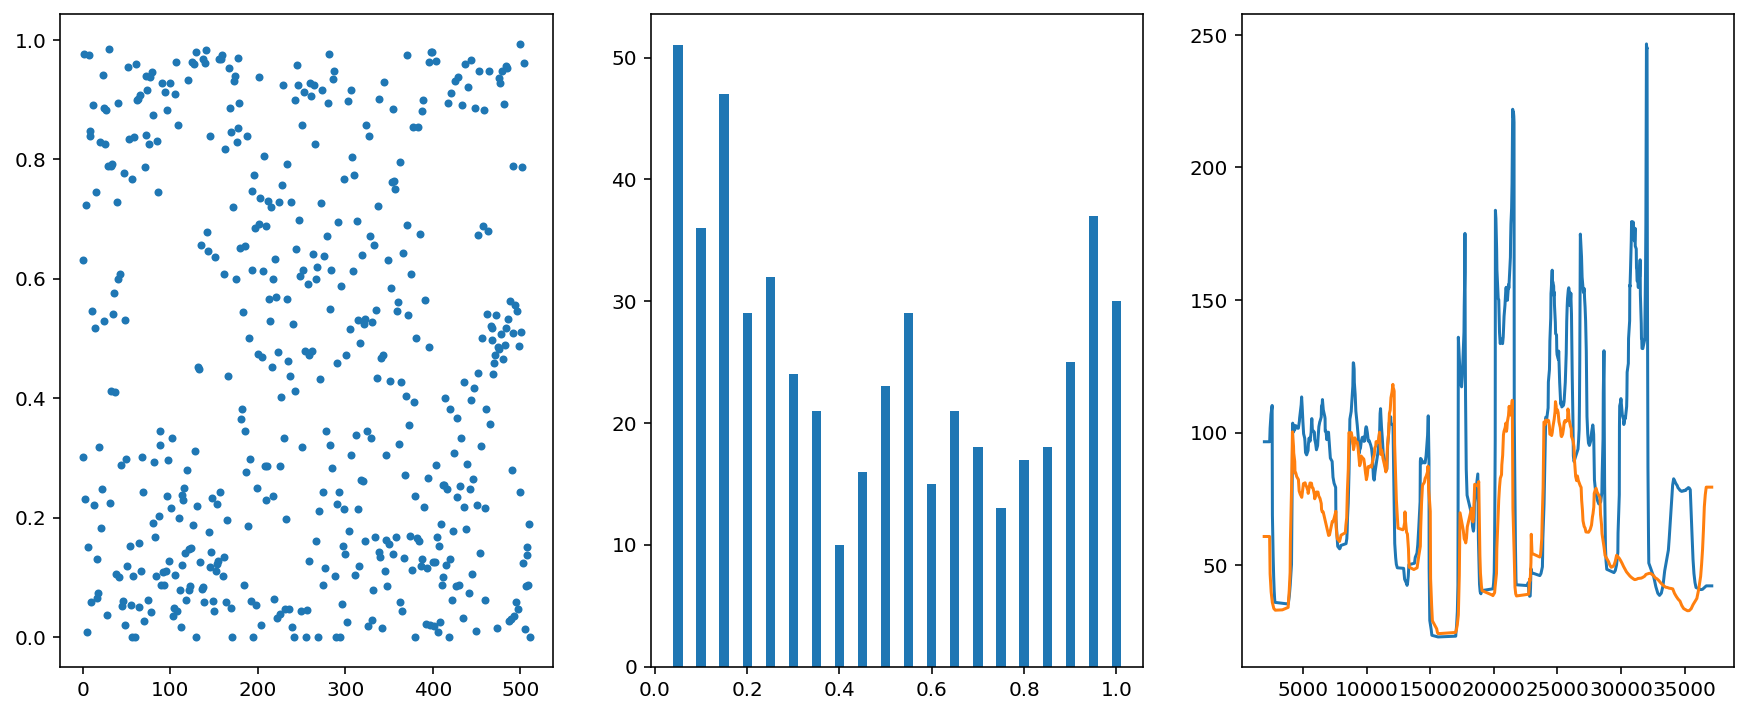

In [519]:
analyze_signals(1007, 43, 45, 1)

filtering 296 and 0 strokes


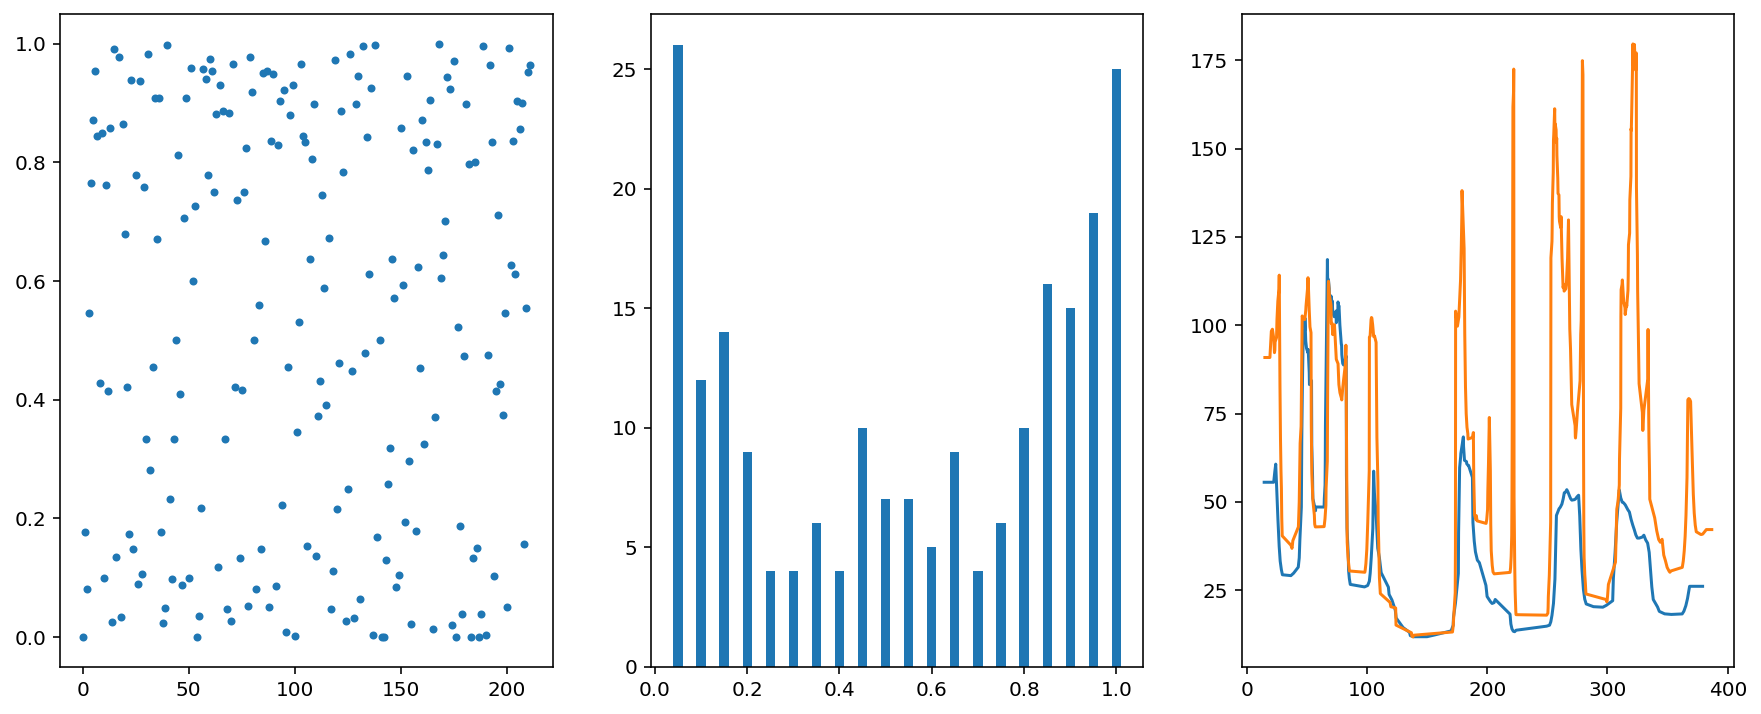

In [41]:
analyze_signals(1007, 45, 48, 1)

filtering 0 and 0 strokes


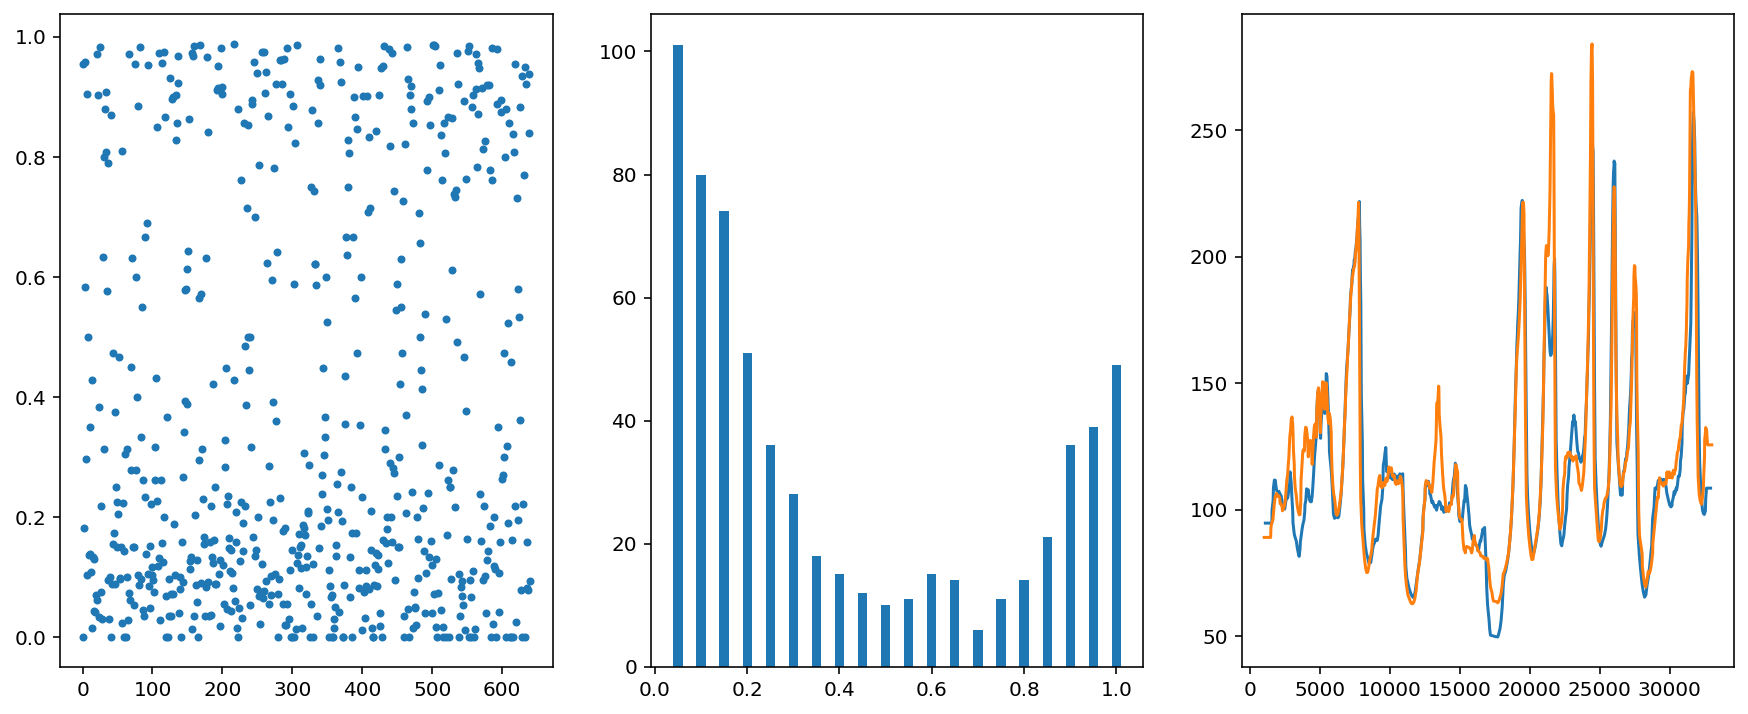

In [518]:
analyze_signals(1008, 48, 45, 1)

filtering 0 and 0 strokes


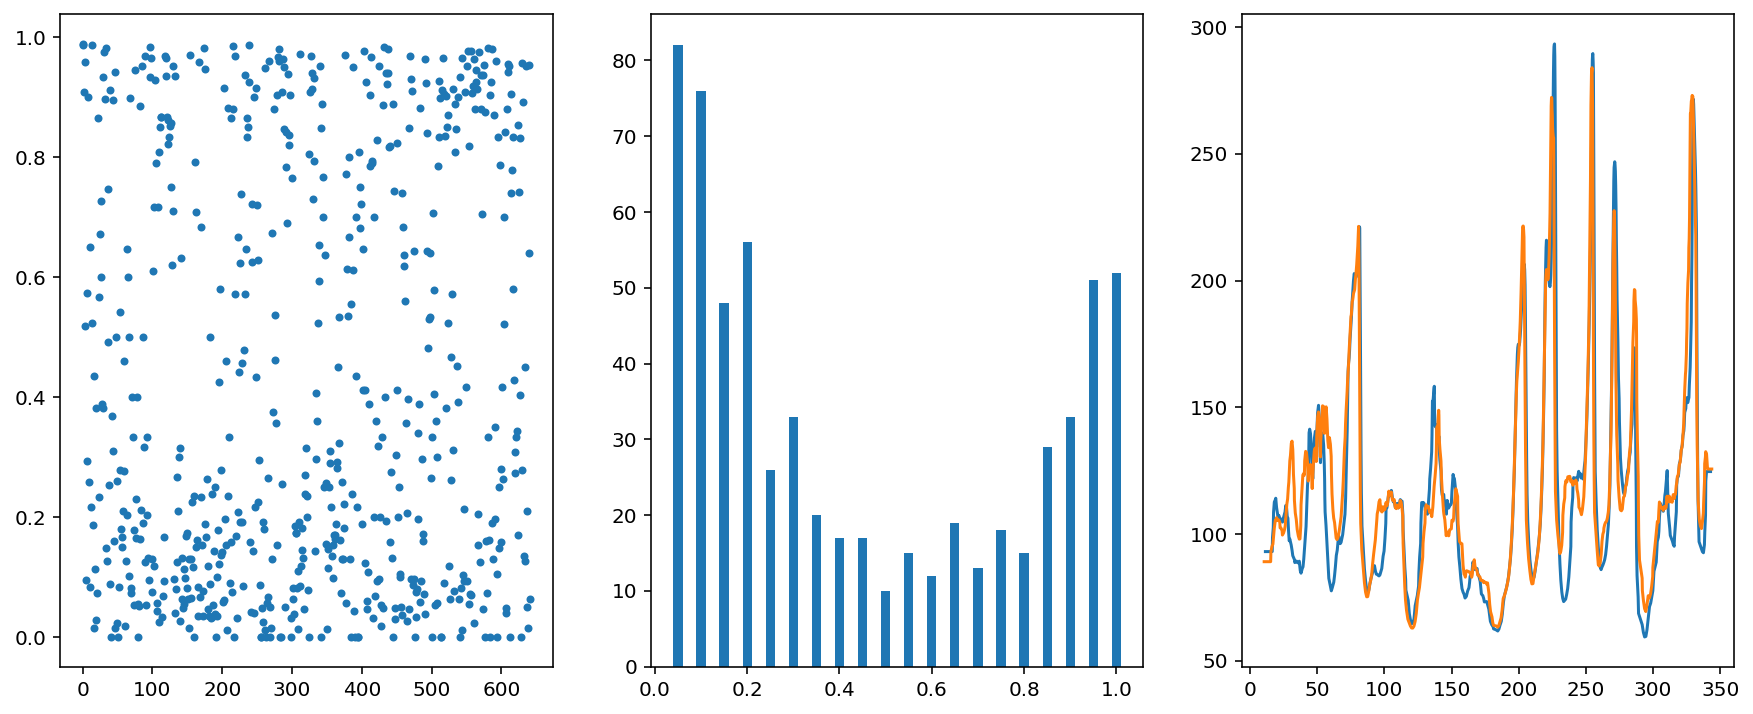

In [542]:
analyze_signals(1008, 48, 43, 1)

filtering 153 and 6 strokes


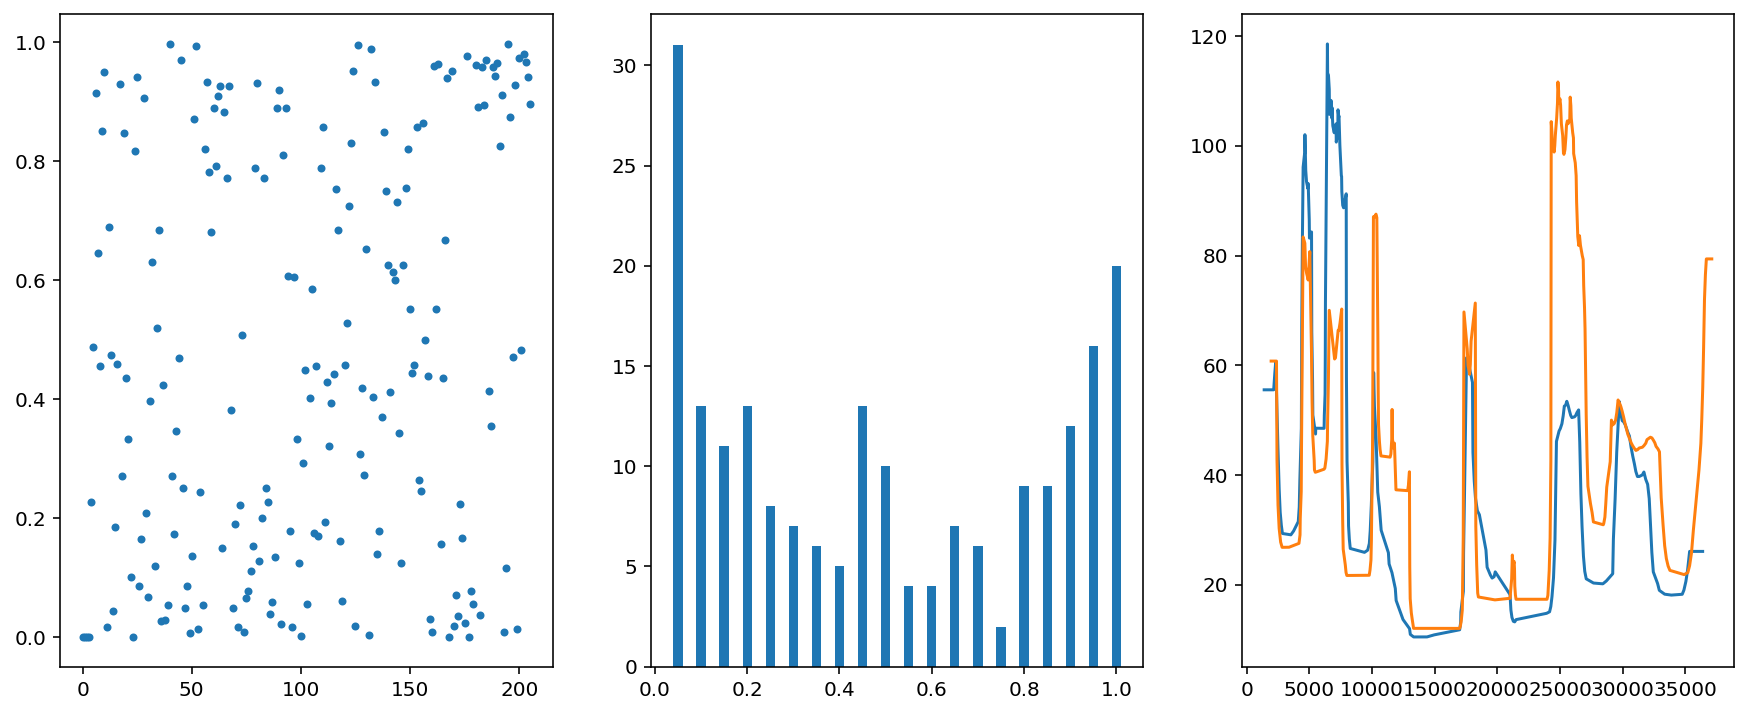

In [520]:
analyze_signals(1007, 43, 48, 1)

filtering 153 and 6 strokes


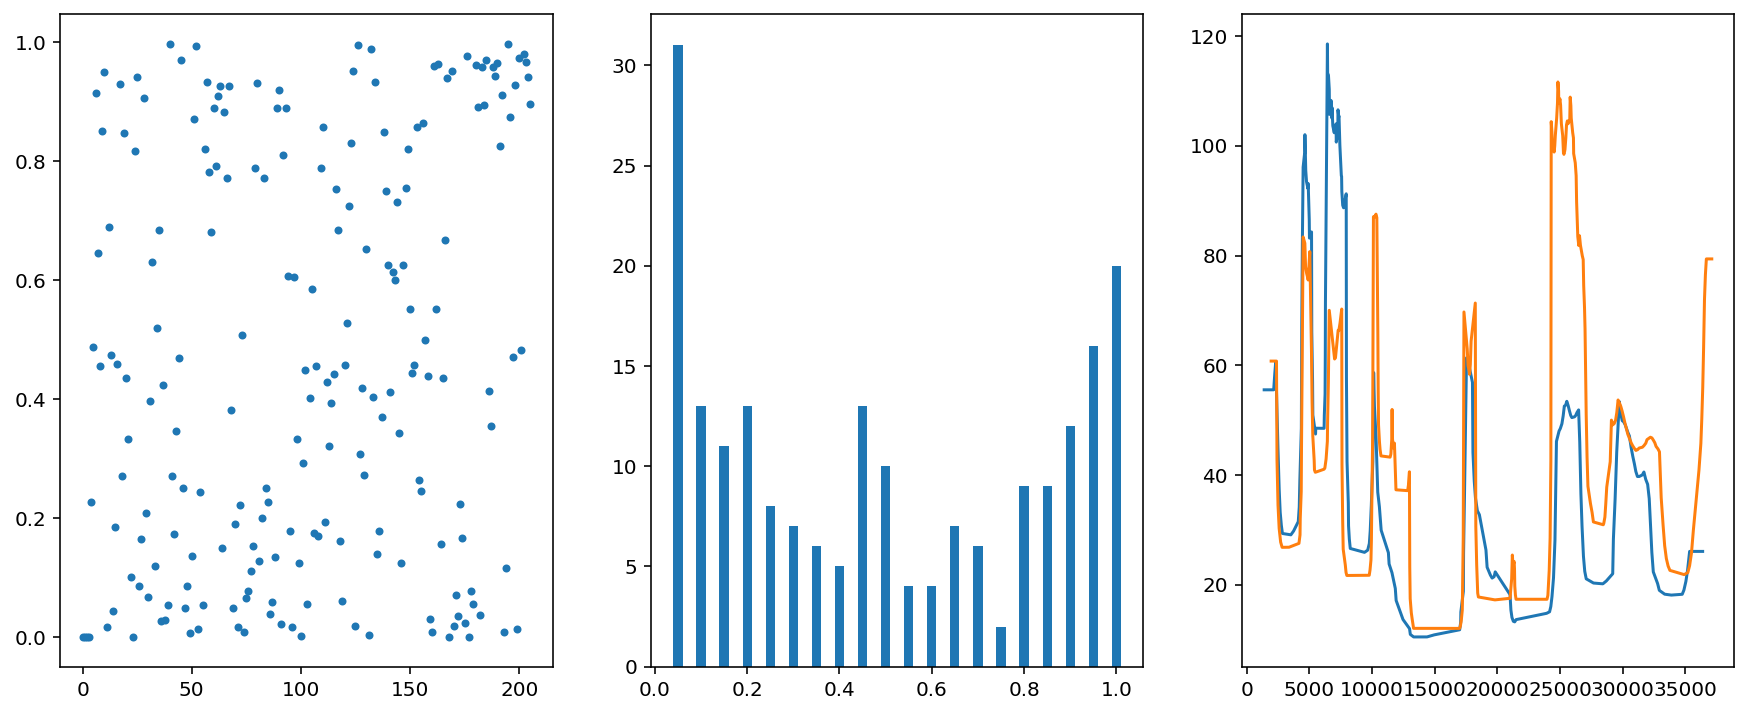

In [521]:
analyze_signals(1007, 43, 48, 1)

[212, 637, 400]
[228, 964, 477]


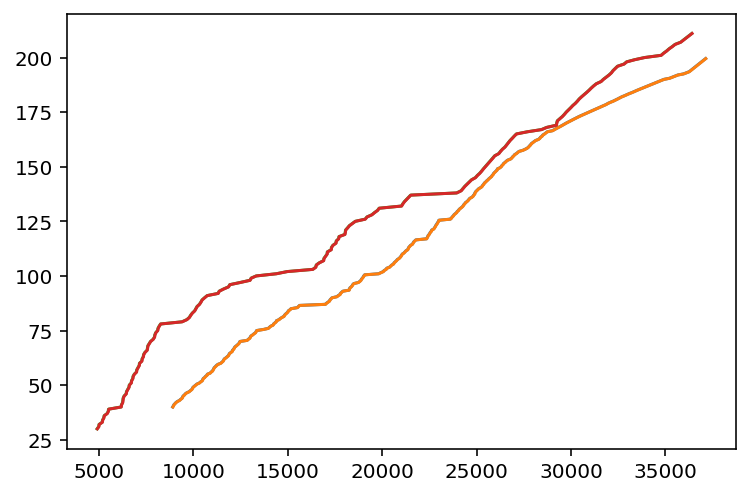

In [221]:
%matplotlib inline
print([len(a) for a in events_filtered[1007].values()])
print([len(a) for a in all_events[1007].values()])
plt.plot(events_filtered[1007][43][80:],np.arange(80,400)/2)
plt.plot(events_filtered[1007][48][30:],np.arange(30,212))

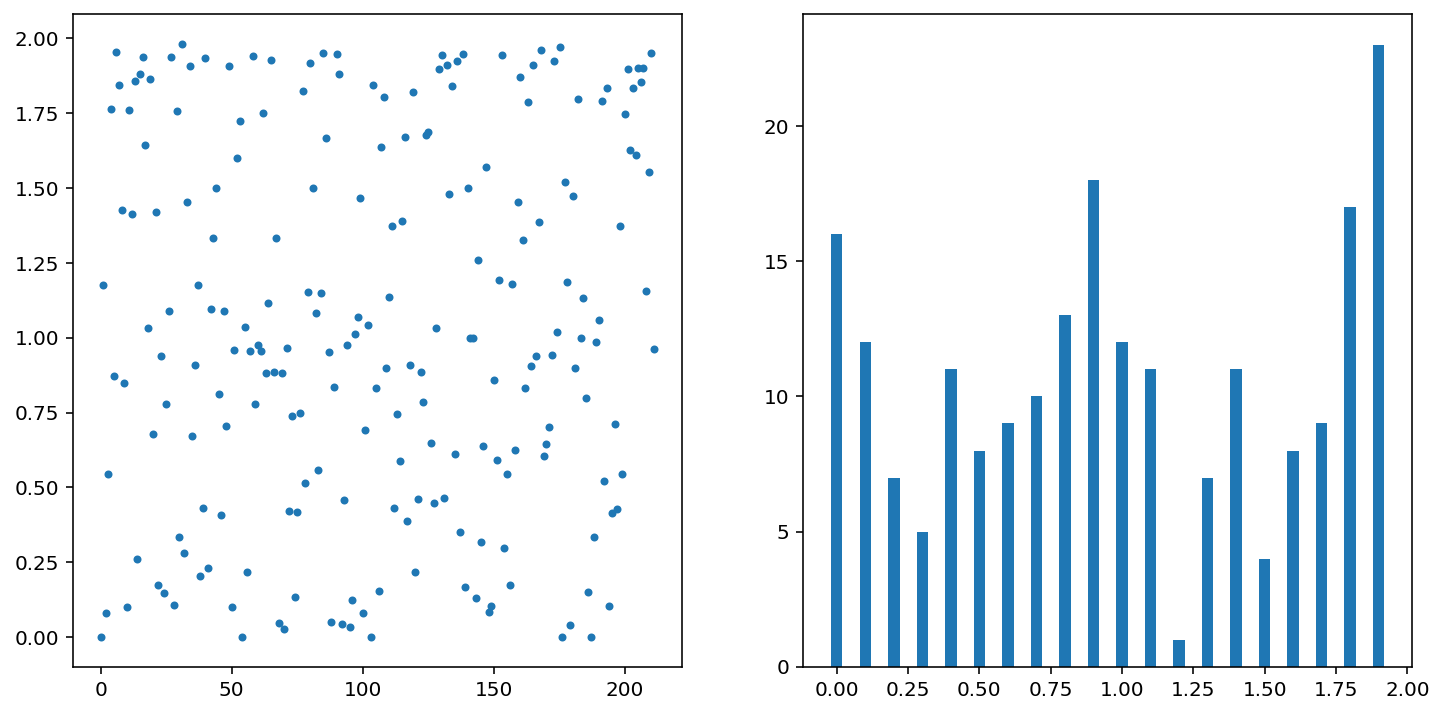

In [200]:
analyze_signals(1007, 45, 48, 2)

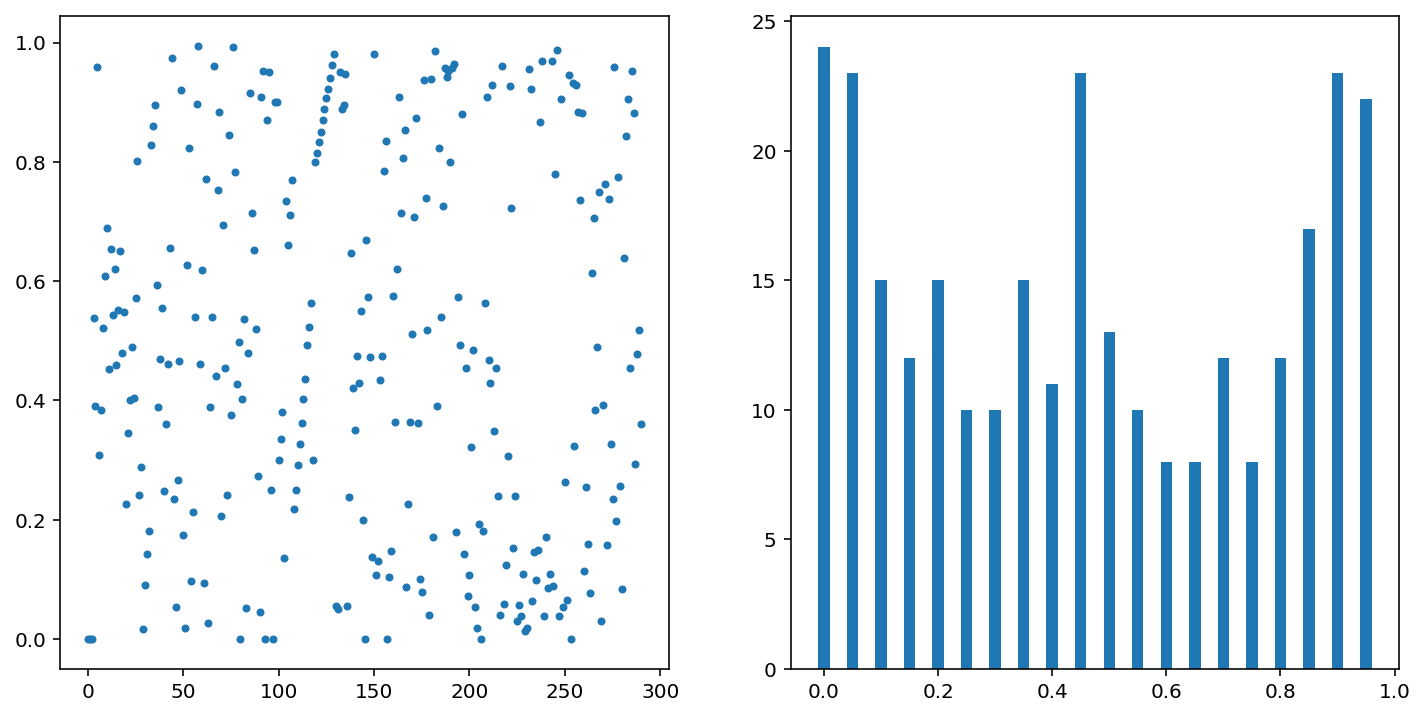

In [208]:
analyze_signals(1011, 43, 48, 1)

In [ ]:
y= np.random.rand(10)*10
y

In [ ]:
y % 1

In [ ]:
np.arange(0.05, 1, 0.05)

array([ 0.        ,  1.17757009,  2.08      ,  4.54545455,  7.76470588,
        8.87058824,  9.9537037 , 11.84375   , 13.42735043, 14.84848485])

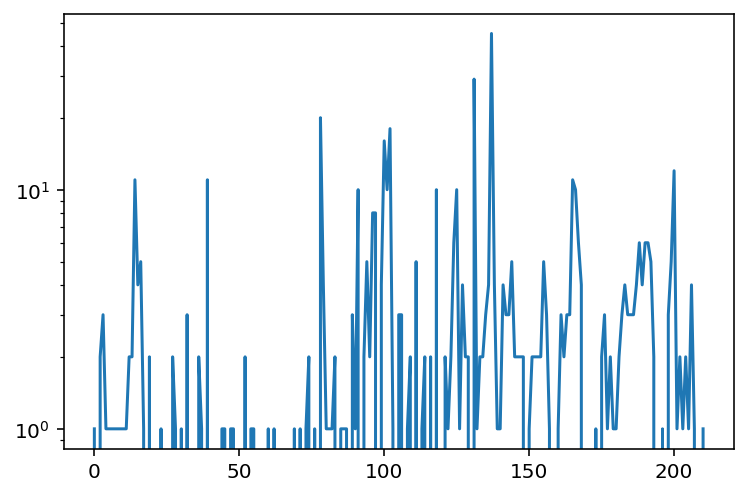

In [228]:
phases = get_relative_phase(events_filtered[1007],45, 48)
plt.plot(np.diff(phases)//1)
plt.yscale('log')
phases[:10]


array([0.33333333, 0.88690476, 1.91666667, 2.60526316, 2.96052632,
       3.03289474, 3.27631579, 3.91447368, 4.05128205, 5.09649123])

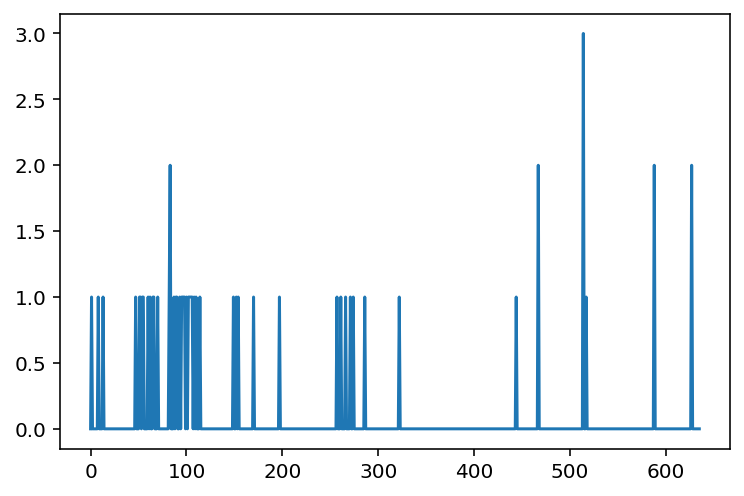

In [230]:
phases = get_relative_phase(events_filtered[1007],48, 45)
plt.plot(np.diff(phases)//1)
#plt.yscale('log')
phases[:10]


In [354]:
v1, v2 = clean_gaps2(events_filtered[1007], 45, 48,4 )

filtering 11 beats of 1 between 2849 and 3524 at index 26 (index 16)
filtering 4 beats of 1 between 3524 and 3741 at index 37 (index 17)
filtering 6 beats of 1 between 3741 and 4114 at index 41 (index 18)
filtering 11 beats of 1 between 5511 and 6176 at index 72 (index 41)
filtering 21 beats of 1 between 8265 and 9400 at index 118 (index 80)
filtering 4 beats of 1 between 9400 and 9655 at index 139 (index 81)
filtering 11 beats of 1 between 10733 and 11309 at index 161 (index 93)
filtering 6 beats of 1 between 11593 and 11860 at index 174 (index 96)
filtering 9 beats of 1 between 11928 and 12477 at index 182 (index 98)
filtering 8 beats of 1 between 12477 and 12997 at index 191 (index 99)
filtering 5 beats of 1 between 13060 and 13326 at index 199 (index 101)
filtering 16 beats of 1 between 13326 and 14392 at index 204 (index 102)
filtering 11 beats of 1 between 14392 and 14970 at index 220 (index 103)
filtering 19 beats of 1 between 14970 and 16320 at index 231 (index 104)
filtering 4

In [324]:
ev = [[a[0] for a in v] for v in (events_filtered[1007][45],events_filtered[1007][48])]

In [357]:
ev[0][514:516], ev[1][168:174]


([28876, 29441], [28706, 29218, 29240, 29272, 29409, 29538])

In [366]:
ev[1][188:197], ev[0][557:567]

([31336, 31585, 31708, 31855, 32007, 32133, 32220, 32342, 32458],
 [31356, 31371, 31458, 31478, 31499, 31517, 31586, 31604, 31625, 31645])

In [353]:
len(ev[0]), len(ev[1])

(637, 212)

In [358]:
v1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [356]:
v2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [300]:
ev[0][36:41], ev[1][15], ev[1][16]

([3530, 3609, 3625, 3681, 3745], 3524, 3741)

In [306]:
ev[1][33:38], ev[0][65:67]

([5173, 5193, 5256, 5277, 5435], [5153, 5197])

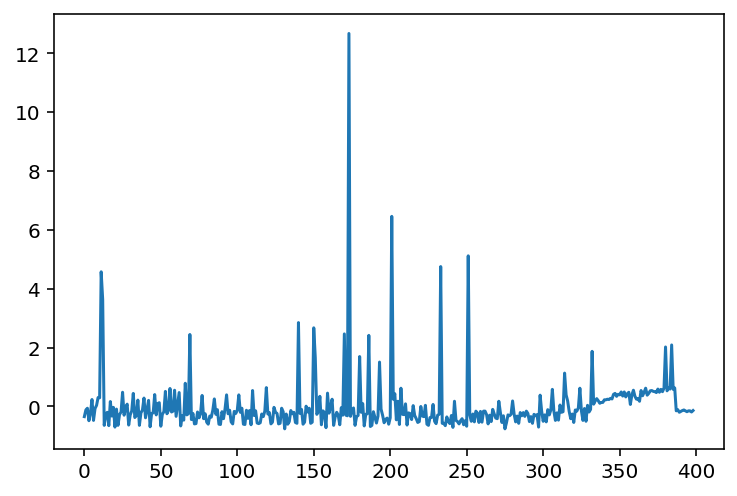

In [439]:
plt.plot(zscore(np.diff(events_filtered[1007][43],axis=0)[:,0]))

In [540]:
len(
    set(map(lambda x: x[0], events_filtered[1007][43])) & 
    set(map(lambda x: x[0], events_filtered[1007][45]))), len(events_filtered[1007][43])

(12, 400)

In [541]:
len(
    set(map(lambda x: x[0], events_filtered[1008][48])) & 
    set(map(lambda x: x[0], events_filtered[1008][45]))), len(events_filtered[1008][45])

(42, 641)

In [534]:
list(map(len, ev))

[637, 212]

In [537]:
len(set(ev[0]) & set(ev[1]))

7